## STAT 430 Final Project

- Author: Lucas Nelson
- Date: TBD

In this notebook, we want to design a playing style vector for each player given enough data of their on-ball actions. This analysis specfically focuses on the 2003-2004 season of Arsenal FC, an English club that competes in the Premier League. Data is provided by StatsBomb OpenAccess.

---

### 00. Imported Libraries

In [78]:
import pandas as pd
import numpy as np

from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

from statsbombpy import sb
from mplsoccer import Pitch, VerticalPitch, FontManager
from mplsoccer.cm import create_transparent_cmap
from mplsoccer.statsbomb import read_event, EVENT_SLUG

import seaborn as sns
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

from warnings import filterwarnings
from statsbombpy.api_client import NoAuthWarning
filterwarnings('ignore', category=NoAuthWarning)
filterwarnings('ignore', category=FutureWarning)

In [2]:
# sb.competitions()

---

### 01. Filtering Play-by-Play Data per Match

In [3]:
invincibles_df = sb.matches(competition_id=2, season_id=44).sort_values('match_date').reset_index(drop=True)

In [4]:
# convert list column to two string columns
list_to_string = lambda x: ','.join([str(i) for i in x])

In [5]:
# yessirrrrrrr
def preprocessing_events_df(
    events_df,
    o_cols=['player', 'location', 'type', 'pass_end_location',
        'shot_outcome', 'dribble_outcome', 'pass_cross', 'shot_statsbomb_xg'],
    o_attrs=['Pass', 'Shot', 'Dribble', 'Cross'],
    time_cols=['match_id', 'minute', 'second']
    ):
    '''
    Return dataframe that contains offense-related metrics
    found in `offensive_cols` and `offensive_attrs`

    > events_df: play-by-play dataframe of team formations,
                 match start/finish, and on-ball actions
    '''

    # events from specific match with valid on-ball player data
    nonempty_df = events_df[(events_df['player_id'].notna()) & (events_df['location'].notna()) & (events_df['team'] == 'Arsenal')][o_cols + time_cols]

    # select specific offensive actions (types)
    nonempty_df = nonempty_df[nonempty_df['type'].isin(o_attrs)]

    # split x,y coordinates of location data
    nonempty_df = pd.merge(
        nonempty_df,
        nonempty_df['location'].apply(list_to_string).str.split(',', expand=True),
        left_index=True, right_index=True, how='outer'
        )
    nonempty_df.rename(columns={0:'location_x', 1:'location_y'}, inplace=True)

    # split x,y coordinates of passing event data
    nonempty_df = pd.merge(
        nonempty_df,
        nonempty_df[nonempty_df['type'] == 'Pass']['pass_end_location'].apply(list_to_string).str.split(',', expand=True),
        left_index=True, right_index=True, how='outer'
        )
    nonempty_df.rename(columns={0:'pass_end_x', 1:'pass_end_y'}, inplace=True)

    # update type column to include crosses
    nonempty_df['type'] = np.where(nonempty_df['pass_cross'] == 1, 'Cross', nonempty_df['type'])

    # return dataframe with desired events
    return nonempty_df.drop(columns=['location', 'pass_end_location'])

We'll store the results in a dataframe that contains all on-ball, offensive-oriented actions performed by Arsenal players in the 33 (of 38) matches provided in this database.

In [6]:
master_df = pd.concat([
    preprocessing_events_df(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

To create our player vectors, we need to first separate out the actions by `player` to distinguish who did what and by `type` to learn more about how often (and - later on - where on the pitch) a player will commit an action. This will be saved in a dictionary for simplified looping later on.

In [7]:
grouped_df = master_df.drop(columns='match_id').groupby(['player', 'type'])

In [8]:
player_dict = {player : dict() for player in master_df['player'].unique()}

for player_type, type_df in grouped_df:
    player_dict[player_type[0]][player_type[1]] = type_df

In [9]:
for player in player_dict:
    for action in ['Pass', 'Shot', 'Dribble', 'Cross']:
        if action not in player_dict[player].keys():
            player_dict[player][action] = pd.DataFrame([player, action, np.nan, np.nan, np.nan, 0, 0, 0, 0, 0, 0, 0]).T
            player_dict[player][action].columns=['player', 'type', 'shot_outcome', 'dribble_outcome', 
                'pass_cross', 'shot_statsbomb_xg', 'minute', 'second',
                'location_x', 'location_y', 'pass_end_x', 'pass_end_y']

---

### 03. Plotting Data

For fun, we'll strictly gather Thierry Henry's shot, pass, dribble, and cross data to visualize each individual heat map below. This will tell us where on the pitch and how often Henry performs each action.

In [10]:
th_shot = player_dict['Thierry Henry']['Shot']
df = th_shot[['location_x', 'location_y']].astype('float64')

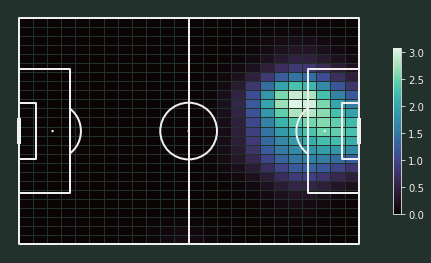

In [11]:
# Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
# asked whether it was possible to plot a Gaussian smoothed heatmap,
# which are available in matplotsoccer. Here is an example demonstrating this.

# setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')
# draw
fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(df.location_x, df.location_y, statistic='count', bins=(24,25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1.5)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='mako', edgecolors='#22312b')
# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
plt.show()

In [12]:
th_pass = player_dict['Thierry Henry']['Pass']
df = th_pass[['location_x', 'location_y']].astype('float64')

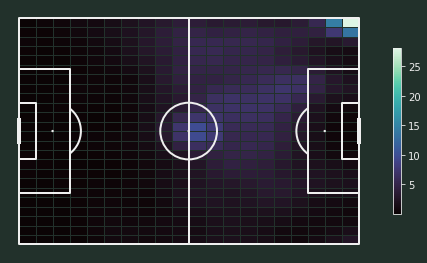

In [13]:
# Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
# asked whether it was possible to plot a Gaussian smoothed heatmap,
# which are available in matplotsoccer. Here is an example demonstrating this.

# setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')
# draw
fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(df.location_x, df.location_y, statistic='count', bins=(20,24))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='mako', edgecolors='#22312b')
# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
plt.show()

In [14]:
th_dribble = player_dict['Thierry Henry']['Dribble']
df = th_dribble[['location_x', 'location_y']].astype('float64')

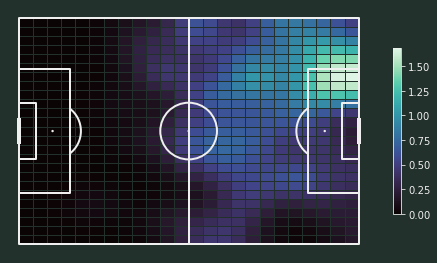

In [15]:
# Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
# asked whether it was possible to plot a Gaussian smoothed heatmap,
# which are available in matplotsoccer. Here is an example demonstrating this.

# setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')
# draw
fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(df.location_x, df.location_y, statistic='count', bins=(24,25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1.5)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='mako', edgecolors='#22312b')
# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
plt.show()

In [16]:
th_cross = player_dict['Thierry Henry']['Cross']
df = th_cross[['location_x', 'location_y']].astype('float64')

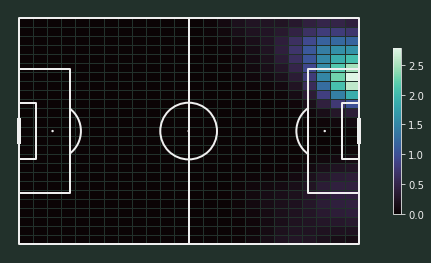

In [17]:
# Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
# asked whether it was possible to plot a Gaussian smoothed heatmap,
# which are available in matplotsoccer. Here is an example demonstrating this.

# setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')
# draw
fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(df.location_x, df.location_y, statistic='count', bins=(24,25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1.5)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='mako', edgecolors='#22312b')
# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
plt.show()

---

#### 02. Aggregate Data for Arsenal

With specific player data out of the way, we can move onto aggregate team data to learn more about the team as a whole.

In [ ]:
def gather_team_data(match_id, events_df):
    return pd.DataFrame(
        {match_id : {
            'xG' : events_df['shot_statsbomb_xg'].astype('float64').sum(),
            'shots' : events_df[events_df['type'] == 'Shot'].shape[0],
            'passes' : events_df[events_df['type'] == 'Pass'].shape[0],
            'dribbles' : events_df[events_df['type'] == 'Dribble'].shape[0],
            'goals' : events_df[events_df['shot_outcome'] == 'Goal'].shape[0]
        }}
    ).T


arsenal_summary_statistics = pd.concat([
    gather_team_data(idx, sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
])

In [ ]:
arsenal_summary_statistics

---

### Minute Data (for scaling)

Let's gather minutes data per player.

In [18]:
def gather_time_information(events_df):
    return events_df[(events_df['player_id'].notna()) & (events_df['team'] == 'Arsenal')][['match_id', 'player', 'minute', 'second']]

In [19]:
time_df = pd.concat([
    gather_time_information(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

In [20]:
time_per_match = time_df.groupby(['player', 'match_id']).agg({'minute': ['min', 'max']})
total_minutes_df = pd.DataFrame(time_per_match['minute']['max'] - time_per_match['minute']['min']).reset_index().groupby(['player', 'match_id']).sum().rename(columns={0:'minutes'})
total_minutes_dict = total_minutes_df.to_dict()

---

#### 04. Heatmaps to Vectors

In [21]:
# keys are action types, values will be dataframes containing each player's compressed heatmap
nmf_dict = {'Pass':[], 'Shot':[], 'Dribble':[], 'Cross':[]}

In [22]:
def player_action_heatmap(player, action, nrows=24, ncols=25):
    if player not in player_dict:
        print(f'Invalid player entry: {player} not found')
        return None
    if action not in player_dict[player]:
        print(f'Invalid action type for {player}: {action} not found')
        return None
    
    player_total_mins = np.sum([total_minutes_dict['minutes'][tup] for tup in total_minutes_dict['minutes'] if tup[0] == player])

    heatmap_dict = {'Pass':[], 'Shot':[], 'Dribble':[], 'Cross':[]}
    # create empty dataframe of specified dimensions
    heatmap_matrix = np.zeros(shape=(nrows, ncols))

    # partition the field evenly (could be altered depending on weights
    # of different grid patterns on the field)
    row_divs = np.round(np.linspace(0, 80, nrows), 2)
    col_divs = np.round(np.linspace(0, 120, ncols), 2)

    # iterate over rows and assign count to specific cell grid
    for _, action in player_dict[player][action][['location_x', 'location_y']].iterrows():
        # assign to closest row grid cell and column grid cell
        grid_row = np.abs(row_divs - np.float64(action['location_y'])).argmin()
        grid_col = np.abs(col_divs - np.float64(action['location_x'])).argmin()
        # argmin index out of bounds if closest to upper bound (nrows, ncols)
        if grid_row == nrows: grid_row -= 1
        if grid_col == ncols: grid_col -= 1
        # update corresponding grid cell (of player-action combo) by one adj. 90-min frequency
        heatmap_matrix[grid_row, grid_col] += 90 / player_total_mins
    
    return gaussian_filter(heatmap_matrix, sigma=1.5)

In [25]:
def compressed_heatmap_matrix(player_action_dict, nrows=24, ncols=25):
    nmf_dict = {action:pd.DataFrame([0]*600, index=range(600), columns=['dummy']) for action in ['Pass', 'Dribble', 'Shot', 'Cross']}
    
    for player in player_action_dict:
        for action in player_action_dict[player]:
            nmf_dict[action][player] = player_action_heatmap(player, action, nrows, ncols).reshape(1, 600)[0]
    
    return {action: nmf_dict[action].drop(columns='dummy') for action in ['Pass', 'Dribble', 'Shot', 'Cross']}

In [26]:
(_, nmf_pass_matrix), (_, nmf_dribble_matrix), (_, nmf_shot_matrix), (_, nmf_cross_matrix) = compressed_heatmap_matrix(player_action_dict=player_dict).items()

---

### 0x. Non-negative Matrix Factoriziation

Let's get into the thick of it. Now that we have a player's shot matrix, let's see what merit we can pull from it.

In [ ]:
for player in nmf_shot_matrix.columns:
    print(f'Current player: {player}')
    sns.heatmap(np.array(nmf_shot_matrix[player]).reshape((24,25)))
    plt.show()

Let's analyze a single action type matrix: pass. Results don't look that great.

In [ ]:
nmf_pass = NMF(n_components=6, random_state=100)
W = pd.DataFrame(nmf_pass.fit_transform(nmf_pass_matrix))
H = pd.DataFrame(nmf_pass.components_, columns=nmf_pass_matrix.columns)
cls_mem = W.apply(lambda x: x / sum(x), axis=1)

In [ ]:
for i in range(W.shape[1]):
    # Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
    # asked whether it was possible to plot a Gaussian smoothed heatmap,
    # which are available in matplotsoccer. Here is an example demonstrating this.

    # reshape vector
    df = np.array(W.iloc[:, i]).reshape((24, 25))
    
    # setup pitch
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
                pitch_color='#22312b', line_color='#efefef')
    # draw
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    fig.set_facecolor('#22312b')
    # bin_statistic = pitch.bin_statistic(df.location_x, df.location_y, statistic='count', bins=(24,25))
    # bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    faux_bin = bin_statistic
    faux_bin['statistic'] = pd.DataFrame(np.array(W.iloc[:, i]).reshape((24, 25))).T
    pcm = pitch.heatmap(faux_bin, ax=ax, cmap='mako', edgecolors='#22312b')
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
    plt.show()

Now repeat with concatenated version of all matrices. First check that indicies line up so that we can perform proper matrix addition.

In [34]:
assert nmf_pass_matrix.shape == nmf_cross_matrix.shape == nmf_dribble_matrix.shape == nmf_shot_matrix.shape

Not let's combine the dataframes.

In [37]:
nmf_combo_matrix = nmf_pass_matrix + nmf_cross_matrix + nmf_dribble_matrix + nmf_shot_matrix

In [38]:
assert nmf_pass_matrix.shape == nmf_cross_matrix.shape == nmf_dribble_matrix.shape == nmf_shot_matrix.shape == nmf_combo_matrix.shape

Now for the grand finale.

In [161]:
nmf_combo = NMF(n_components=18, random_state=100)
W = pd.DataFrame(nmf_combo.fit_transform(nmf_combo_matrix))
H = pd.DataFrame(nmf_combo.components_, columns=nmf_combo_matrix.columns)
cls_mem = W.apply(lambda x: x / sum(x), axis=1)

NMF Component #0


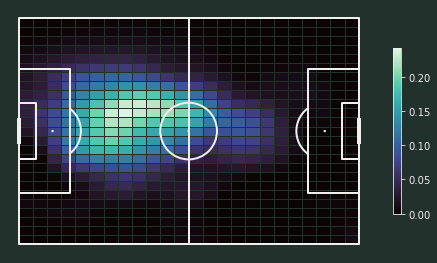

NMF Component #1


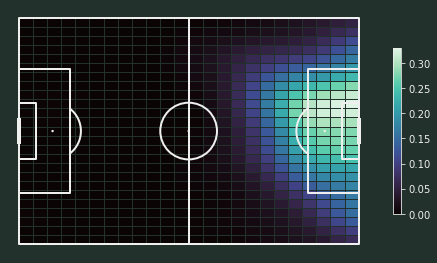

NMF Component #2


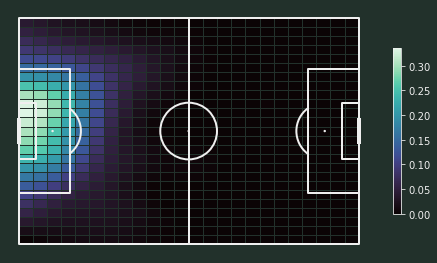

NMF Component #3


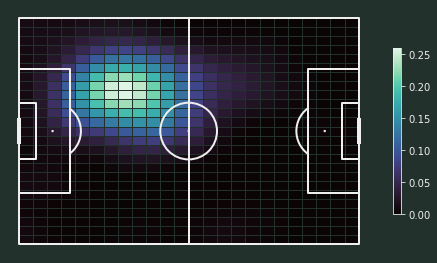

NMF Component #4


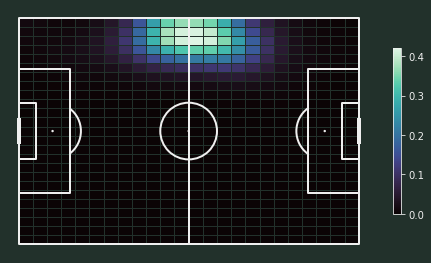

NMF Component #5


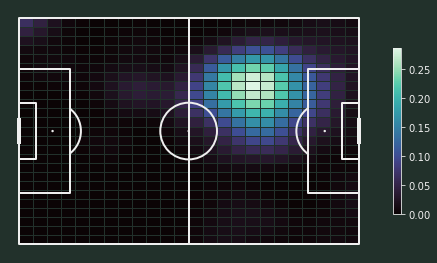

NMF Component #6


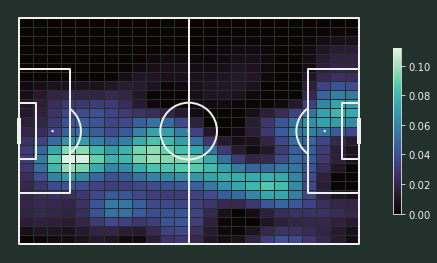

NMF Component #7


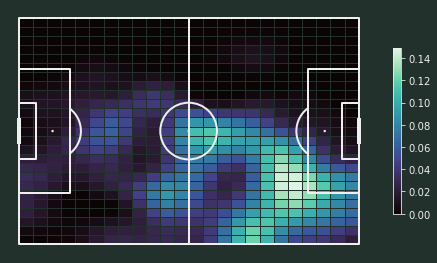

NMF Component #8


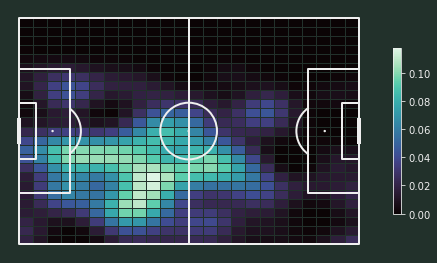

NMF Component #9


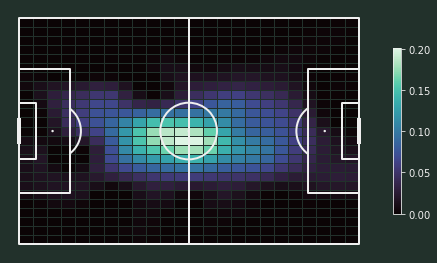

NMF Component #10


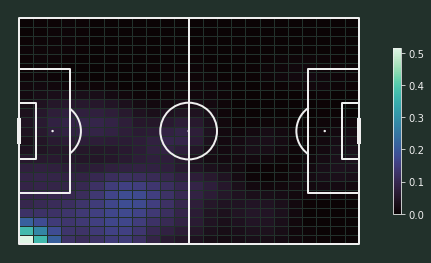

NMF Component #11


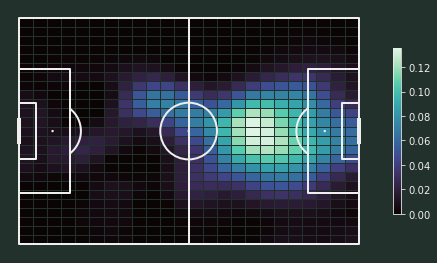

NMF Component #12


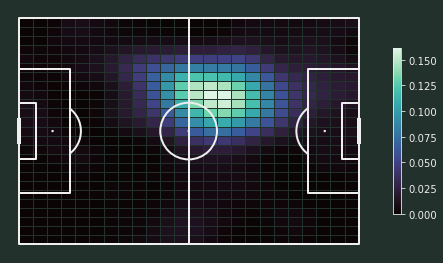

NMF Component #13


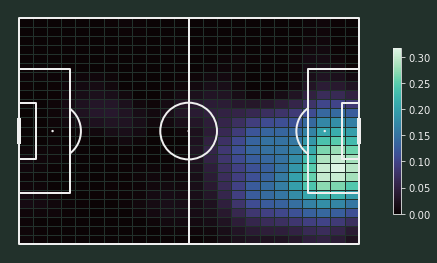

NMF Component #14


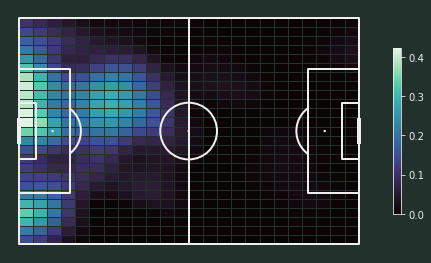

NMF Component #15


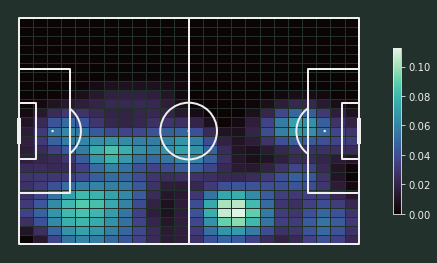

NMF Component #16


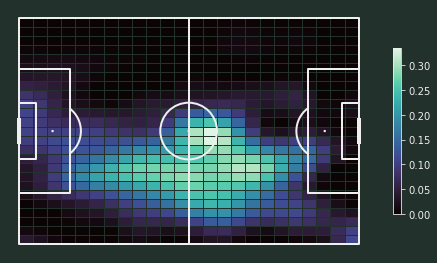

NMF Component #17


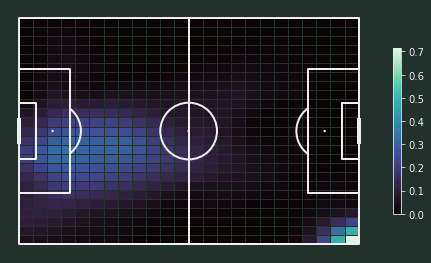

In [162]:
for i in range(W.shape[1]):
    # Tom Decroos, author of `matplotsoccer <https://github.com/TomDecroos/matplotsoccer>`_,
    # asked whether it was possible to plot a Gaussian smoothed heatmap,
    # which are available in matplotsoccer. Here is an example demonstrating this.

    # reshape vector
    df = np.array(W.iloc[:, i]).reshape((24, 25))
    print(f'NMF Component #{i}')
    
    # setup pitch
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
                pitch_color='#22312b', line_color='#efefef')
    # draw
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    fig.set_facecolor('#22312b')
    # bin_statistic = pitch.bin_statistic(df.location_x, df.location_y, statistic='count', bins=(24,25))
    # bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    faux_bin = bin_statistic
    faux_bin['statistic'] = pd.DataFrame(np.array(W.iloc[:, i]).reshape((24, 25))).T
    pcm = pitch.heatmap(faux_bin, ax=ax, cmap='mako', edgecolors='#22312b')
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
    plt.show()

In [170]:
player_vector_henry = pd.DataFrame(np.array(np.matmul(W, H['Thierry Henry'])).reshape((24, 25)))

> SYLVAIN WILTORD


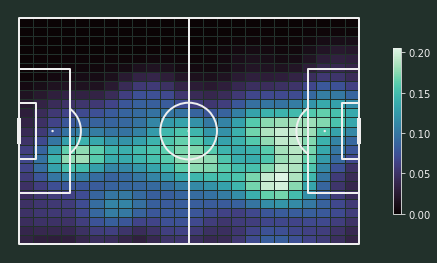

> PATRICK VIEIRA


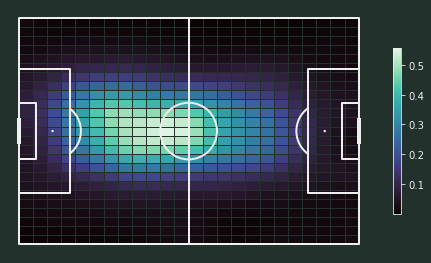

> LAUREANO BISAN-ETAME MAYER


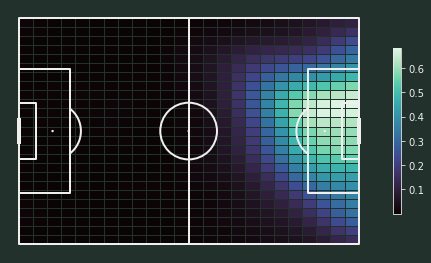

> FREDRIK LJUNGBERG


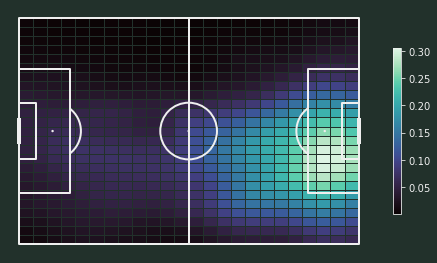

> GILBERTO APARECIDO DA SILVA


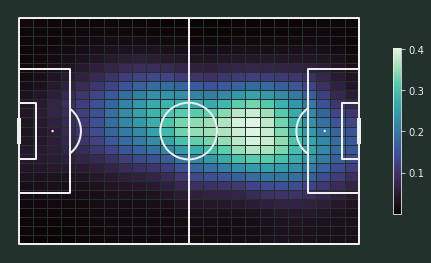

> KOLO HABIB TOURÉ


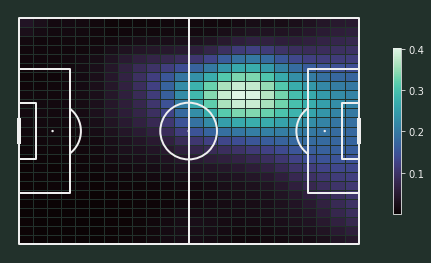

> JENS LEHMANN


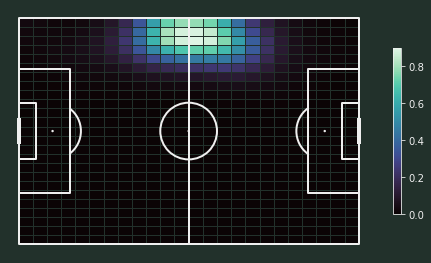

> ROBERT PIRÈS 


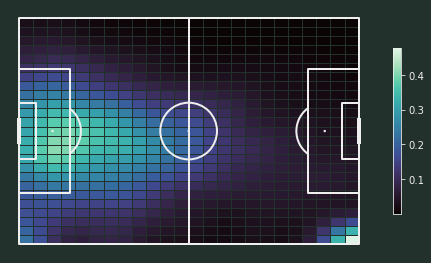

> ASHLEY COLE


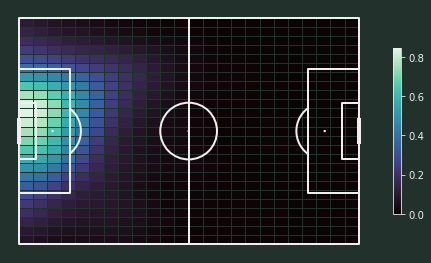

> SULZEER JEREMIAH "SOL" CAMPBELL


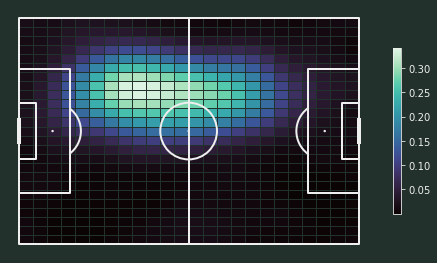

> THIERRY HENRY


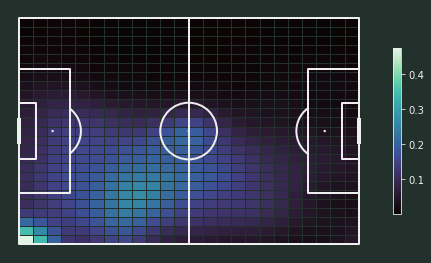

> MARTIN KEOWN


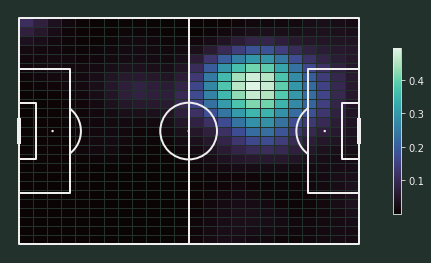

> RAY PARLOUR


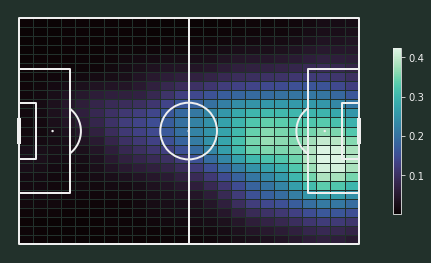

> EDUARDO CÉSAR DAUDE GASPAR


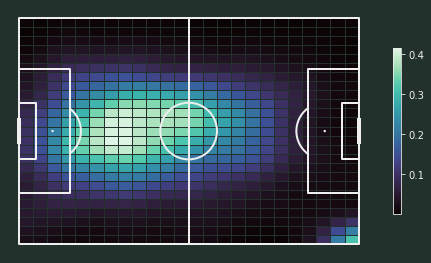

> DENNIS BERGKAMP


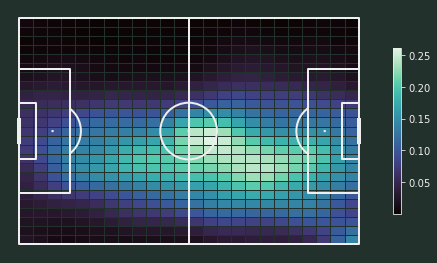

> PASCAL CYGAN


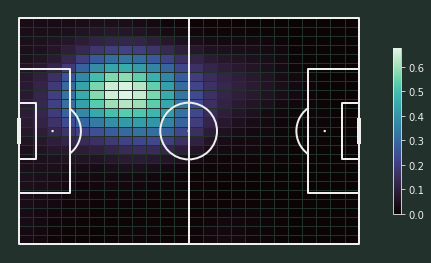

> JÉRÉMIE ALIADIÈRE


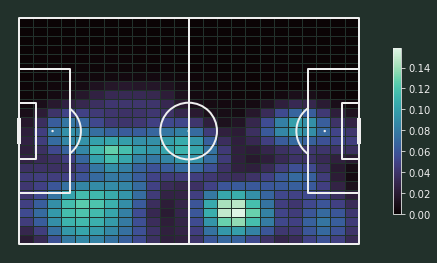

> NWANKWO CHRISTIAN KANU


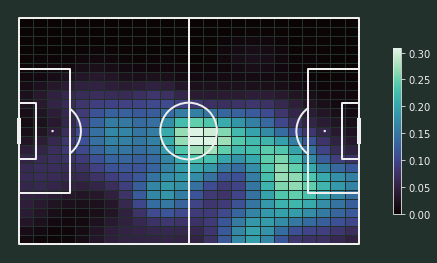

> GAËL CLICHY


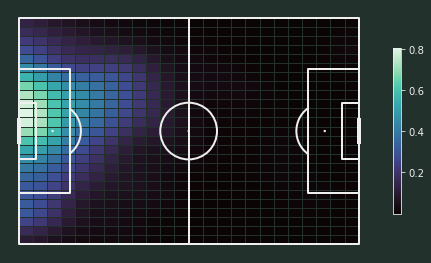

> JOSÉ ANTONIO REYES CALDERÓN


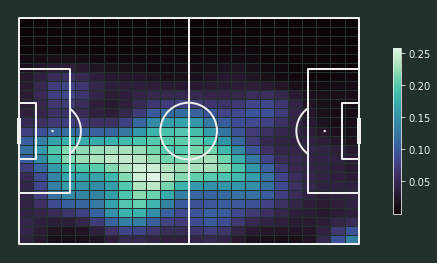

In [173]:
for player in H.columns:
    print(f'> {player.upper()}')
    player_vector = pd.DataFrame(np.array(np.matmul(W, H[player])).reshape((24, 25)))

    pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
                pitch_color='#22312b', line_color='#efefef')
    # draw
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    fig.set_facecolor('#22312b')
    # bin_statistic = pitch.bin_statistic(df.location_x, df.location_y, statistic='count', bins=(24,25))
    # bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    faux_bin = bin_statistic
    faux_bin['statistic'] = player_vector.T
    pcm = pitch.heatmap(faux_bin, ax=ax, cmap='mako', edgecolors='#22312b')
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
    plt.show()
    print('='*80)

<AxesSubplot:ylabel='Thierry Henry'>

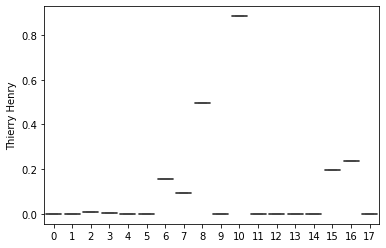

In [167]:
sns.boxplot(x=H['Thierry Henry'].index, y=H['Thierry Henry'])

---

#### Trial Experiments

#### Data Extraction

###### **COMPONENT WITH HEAVY FAVOR FOR LOCATION<40 IS CONSIDERING BACKPASSES TO KEEPER AND EXTENDED DRIBBLES**

In [192]:
offensive_df = master_df[master_df['type'].isin(['Pass', 'Shot', 'Dribble', 'Cross'])].copy()
offensive_df[['location_x', 'location_y']] = offensive_df[['location_x', 'location_y']].astype('float64')

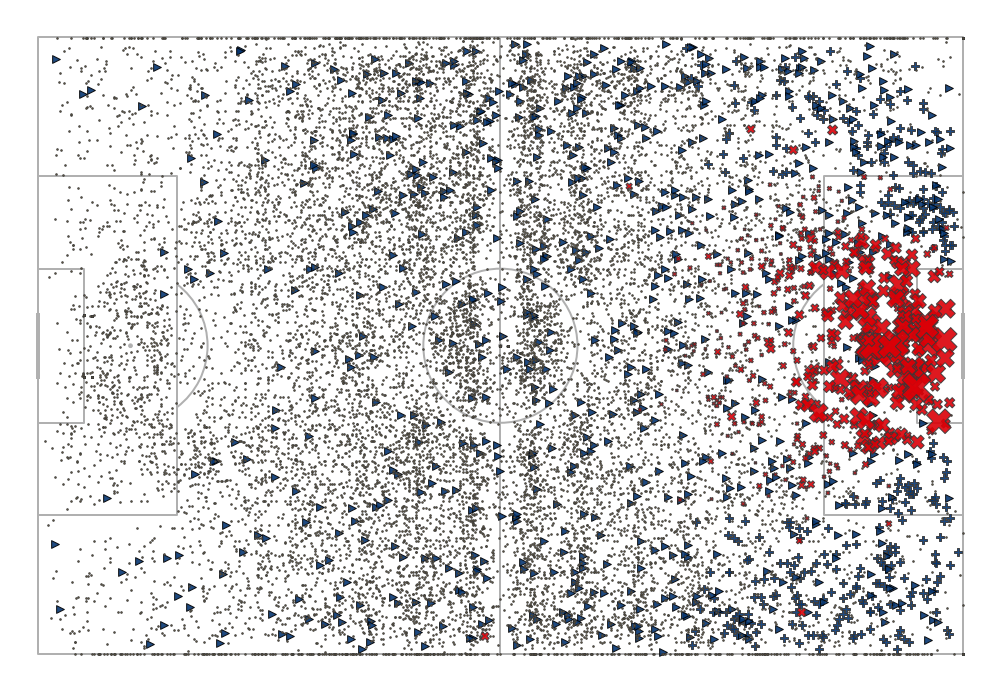

In [223]:
pitch = Pitch()
fig, ax = pitch.draw(figsize=(14, 12))


cross_df = offensive_df[offensive_df['type'] == 'Cross']
sc1 = pitch.scatter(cross_df['location_x'], cross_df['location_y'],
                   c='#063672',  # color for scatter in hex format
                   s=60, marker='P',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

dribble_df = offensive_df[offensive_df['type'] == 'Dribble']
sc1 = pitch.scatter(dribble_df['location_x'], dribble_df['location_y'],
                   c='#063672',  # color for scatter in hex format,
                   s=60, marker='>',
                   edgecolors='#000000', alpha=0.9,
                   ax=ax)

pass_df = offensive_df[offensive_df['type'] == 'Pass']
sc2 = pitch.scatter(pass_df['location_x'], pass_df['location_y'],
                   c='#9C824A',  # color for scatter in hex format
                   s=10, marker='.',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

shot_df = offensive_df[offensive_df['type'] == 'Shot']
sc3 = pitch.scatter(shot_df['location_x'], shot_df['location_y'],
                   c='#DB0007',  # color for scatter in hex format
                   s=shot_df['shot_statsbomb_xg'] * 900,
                   marker='X',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

plt.show()  # If you are using a Jupyter notebook you do not need this line

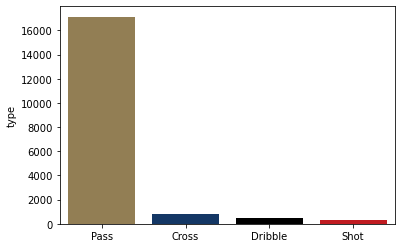

In [228]:
sns.barplot(x=offensive_df['type'].unique(), y=offensive_df['type'].value_counts(), palette=['#9C824A', '#063672', '#000000', '#DB0007'])
plt.show()

In [224]:
aggresive_df = master_df[(master_df['location_x'].astype('float64') >= 40) & (master_df['type'].isin(['Pass', 'Shot', 'Dribble', 'Cross']))].copy()
aggresive_df[['location_x', 'location_y']] = aggresive_df[['location_x', 'location_y']].astype('float64')

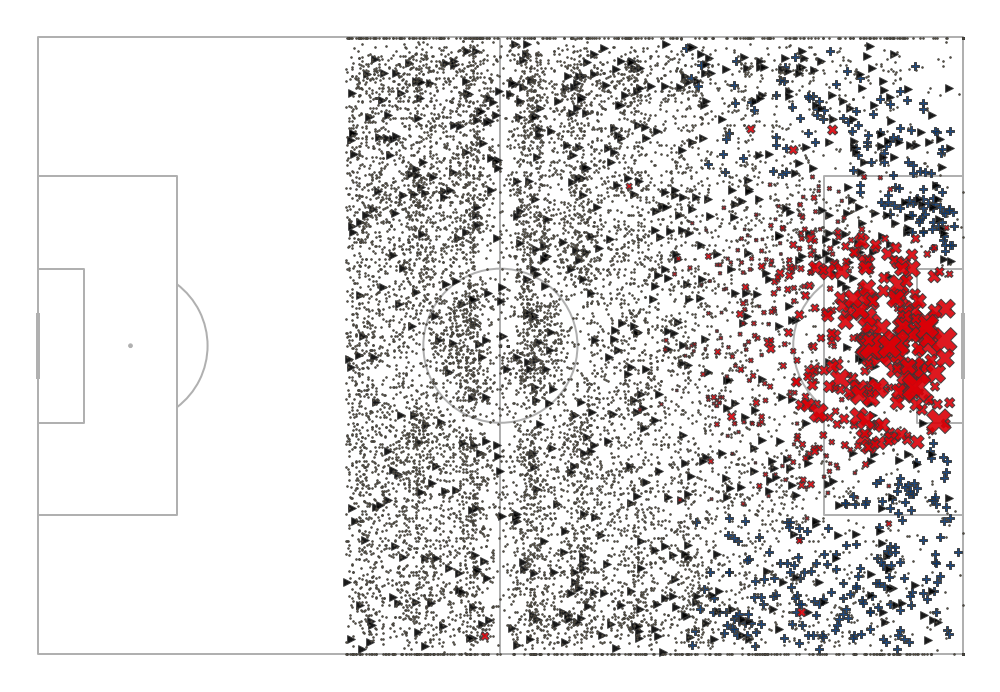

In [225]:
pitch = Pitch()
fig, ax = pitch.draw(figsize=(14, 12))


cross_df = aggresive_df[aggresive_df['type'] == 'Cross']
sc1 = pitch.scatter(cross_df['location_x'], cross_df['location_y'],
                   c='#063672',  # color for scatter in hex format
                   s=60, marker='P',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

dribble_df = aggresive_df[aggresive_df['type'] == 'Dribble']
sc1 = pitch.scatter(dribble_df['location_x'], dribble_df['location_y'],
                   c='#000000',  # color for scatter in hex format,
                   s=60, marker='>',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

pass_df = aggresive_df[aggresive_df['type'] == 'Pass']
sc2 = pitch.scatter(pass_df['location_x'], pass_df['location_y'],
                   c='#9C824A',  # color for scatter in hex format
                   s=10, marker='.',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

shot_df = aggresive_df[aggresive_df['type'] == 'Shot']
sc3 = pitch.scatter(shot_df['location_x'], shot_df['location_y'],
                   c='#DB0007',  # color for scatter in hex format
                   s=shot_df['shot_statsbomb_xg'] * 900,
                   marker='X',
                   edgecolors='#383838', alpha=0.9,
                   ax=ax)

plt.show()  # If you are using a Jupyter notebook you do not need this line

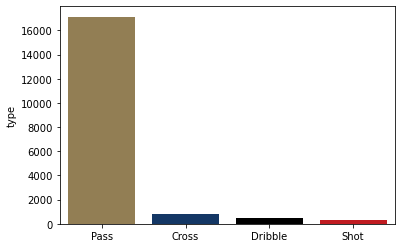

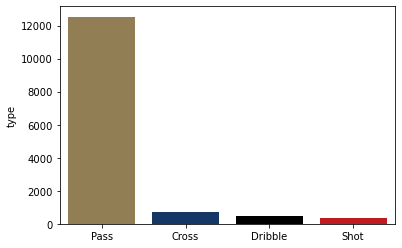

In [227]:
sns.barplot(x=aggresive_df['type'].unique(), y=aggresive_df['type'].value_counts(), palette=['#9C824A', '#063672', '#000000', '#DB0007'])
plt.show()

#### Plots

###### **> Arsenal Shot Distribution**

In [85]:
vertical_pitch = VerticalPitch(half=True, pad_top=0.05, pad_right=0.05, pad_bottom=0.05,
                               pad_left=0.05, line_zorder=2)
fm = FontManager()
fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))

In [89]:
arsenal_shot_df = master_df[master_df['type'] == 'Shot'].copy()
arsenal_shot_df[['location_x', 'location_y']] = arsenal_shot_df[['location_x', 'location_y']].astype('float64')

###### **> Marked Shot Distribution**

In [102]:
fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))
pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency

In [106]:
# filter goals / non-shot goals
arsenal_non_goal_df = master_df[(master_df['type'] == 'Shot') & (master_df['shot_outcome'] != 'Goal')].copy()
arsenal_non_goal_df[['location_x', 'location_y']] = arsenal_non_goal_df[['location_x', 'location_y']].astype('float64')
arsenal_goal_df = master_df[(master_df['type'] == 'Shot') & (master_df['shot_outcome'] == 'Goal')].copy()
arsenal_goal_df[['location_x', 'location_y']] = arsenal_goal_df[['location_x', 'location_y']].astype('float64')

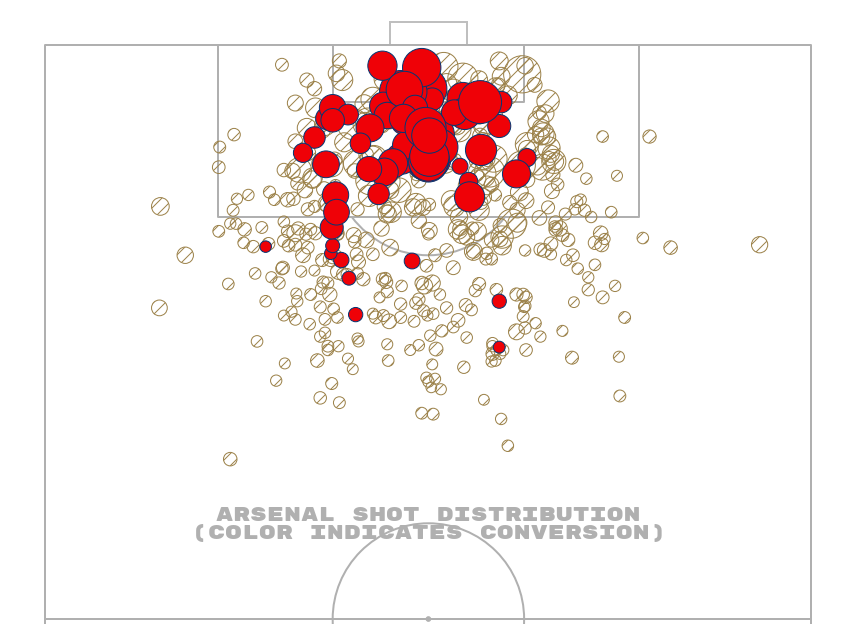

In [130]:
fig, ax = pitch.draw(figsize=(12, 10))

# plot non-goal shots with hatch
sc1 = pitch.scatter(arsenal_non_goal_df['location_x'], arsenal_non_goal_df['location_y'],
                    # size varies between 100 and 1900 (points squared)
                    s=(arsenal_non_goal_df['shot_statsbomb_xg'] * 1900) + 100,
                    edgecolors='#9C824A',  # give the markers a charcoal border
                    c='None',  # no facecolor for the markers
                    hatch='//',  # the all important hatch (triple diagonal lines)
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',
                    ax=ax)

# plot goal shots with a color
sc2 = pitch.scatter(arsenal_goal_df['location_x'], arsenal_goal_df['location_y'],
                    # size varies between 100 and 1900 (points squared)
                    s=(arsenal_goal_df['shot_statsbomb_xg'] * 1900) + 100,
                    edgecolors='#063672',  # give the markers a charcoal border
                    c='#EF0107',  # color for scatter in hex format
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',
                    ax=ax)

team2_hist_x = sns.kdeplot(y=arsenal_goal_df['location_x'], ax=axs['right'], color='#697cd4', shade=True)
team2_hist_y = sns.kdeplot(x=arsenal_goal_df['location_y'], ax=axs['bottom'], color='#697cd4', shade=True)

txt = ax.text(x=40, y=70, s='Arsenal Shot Distribution\n(color indicates conversion)',
              size=20,
              # here i am using a downloaded font from google fonts instead of passing a fontdict
              fontproperties=fm_rubik.prop, color=pitch.line_color,
              va='center', ha='center')

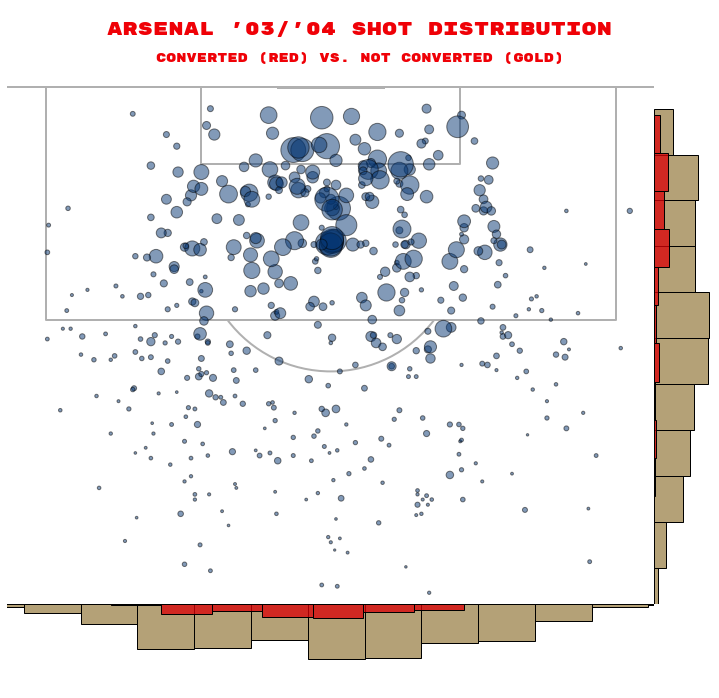

In [152]:
vertical_pitch = VerticalPitch(half=True,
                               # here we remove some of the pitch on the left/ right/ bottom
                               pad_top=0.05, pad_right=-15, pad_bottom=-20, pad_left=-15,
                               goal_type='line')

fig, axs = vertical_pitch.jointgrid(figheight=10, left=None, bottom=None,  # center aligned
                                    grid_width=0.95, marginal=0.1,
                                    # setting up the heights/space so it takes up 95% of the figure
                                    grid_height=0.80,
                                    title_height=0.1, endnote_height=0.03,
                                    title_space=0.01, endnote_space=0.01,
                                    axis=False,  # turn off title/ endnote/ marginal axes
                                    # here we filter out the left and top marginal axes
                                    ax_top=False, ax_bottom=True,
                                    ax_left=False, ax_right=True)

# typical shot map where the scatter points vary by the expected goals value
# using alpha for transparency as there are a lot of shots stacked around the six-yard box
sc_team2 = vertical_pitch.scatter(arsenal_shot_df['location_x'], arsenal_shot_df['location_y'], s=arsenal_shot_df['shot_statsbomb_xg'] * 700,
                                  alpha=0.5, ec='black', color='#063672', ax=axs['pitch'])
# kdeplots on the marginals
# remember to flip the coordinates y=x, x=y for the marginals when using vertical orientation
team2_hist_x = sns.histplot(y=arsenal_non_goal_df['location_x'], ax=axs['right'], color='#9C824A')
team2_hist_y = sns.histplot(x=arsenal_non_goal_df['location_y'], ax=axs['bottom'], color='#9C824A')
team2_hist_x = sns.histplot(y=arsenal_goal_df['location_x'], ax=axs['right'], color='#DB0007')
team2_hist_y = sns.histplot(x=arsenal_goal_df['location_y'], ax=axs['bottom'], color='#DB0007')

# titles and endnote
axs['title'].text(0.5, 0.7, "Arsenal '03/'04 Shot Distribution", color='#EF0107',
                  fontproperties=fm_rubik.prop, fontsize=18, ha='center', va='center')
axs['title'].text(0.5, 0.3, "Converted (red) vs. Not Converted (gold)", color='#EF0107',
                  fontproperties=fm_rubik.prop, fontsize=12, ha='center', va='center')

plt.show()  # If you are using a Jupyter notebook you do not need this line